In [1]:
# Requirement for the next library
%pip install cffi

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.


In [2]:
# To read the labcharts files
%pip install adi-reader

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.


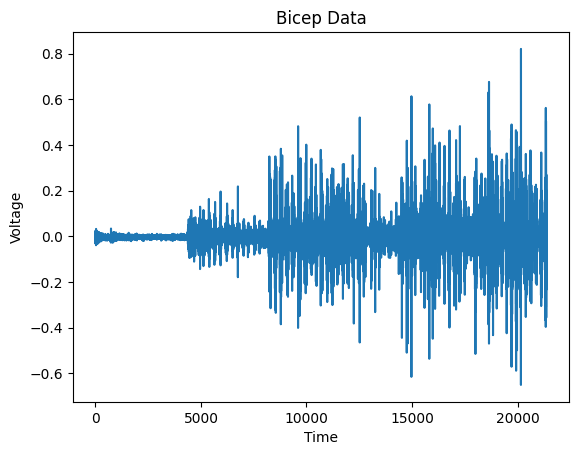

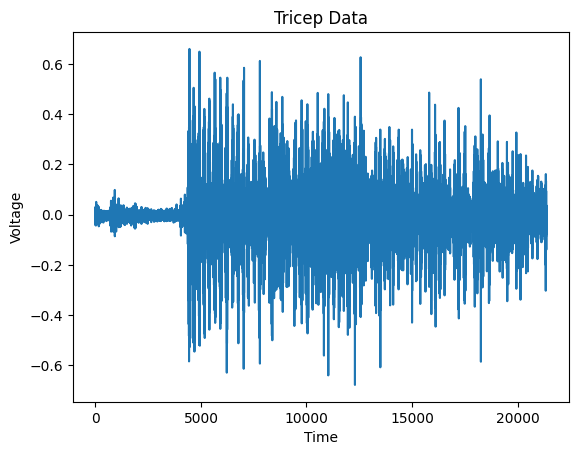

In [3]:
# Importing the required libraries
import adi
import matplotlib.pyplot as plt

# Reading the labChart file 
f = adi.read_file(r'Experiment 2.adicht')

# Storing the data of the two channels
record_id = 1
data_1 = f.channels[2].get_data(record_id)
data_2 = f.channels[3].get_data(record_id)
   
# Plotting data_1 in the first figure
plt.figure(1)
plt.plot(data_1)
plt.title('Bicep Data')
plt.xlabel('Time')
plt.ylabel('Voltage')

# Plotting data_2 in the second figure
plt.figure(2)
plt.plot(data_2)
plt.title('Tricep Data')
plt.xlabel('Time')
plt.ylabel('Voltage')

# Showing both plots
plt.show()


### Part A

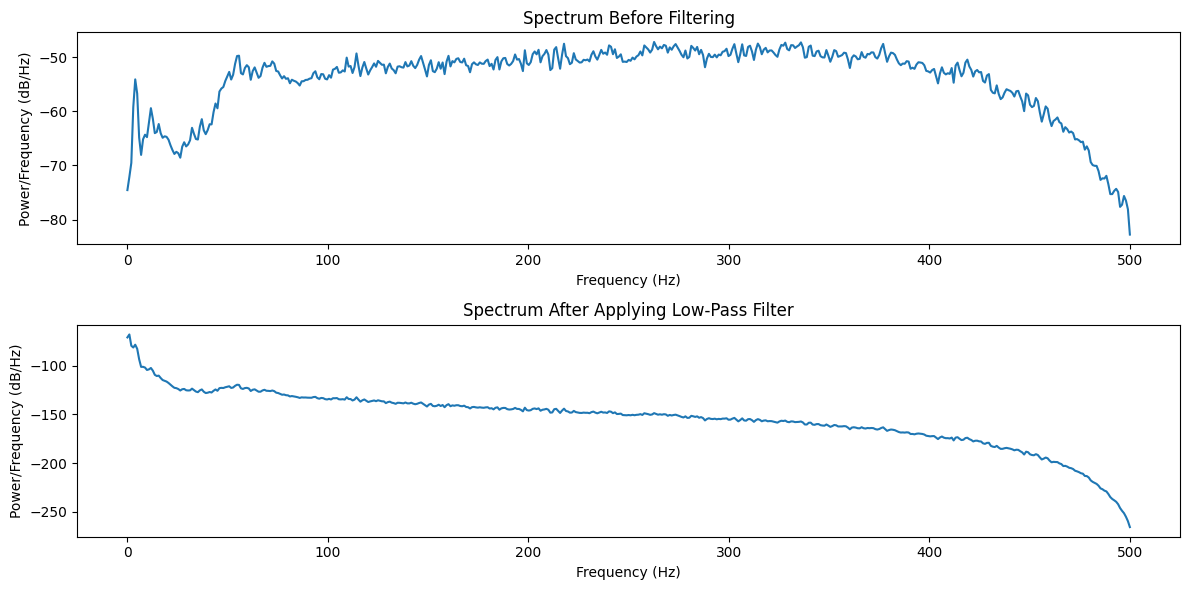

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch

fs = 1000 
# Butterworth filter
cutoff_frequency = 1
order = 1 
b, a = butter(order, cutoff_frequency, fs=fs, btype='low')
filtered_emg = filtfilt(b, a, data_1)

# Before filtering
frequencies_before, spectrum_before = welch(data_1, fs=fs, nperseg=1024)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencies_before, 10 * np.log10(spectrum_before))
plt.title('Spectrum Before Filtering')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

# After filtering
frequencies_after, spectrum_after = welch(filtered_emg, fs=fs, nperseg=1024)
plt.subplot(2, 1, 2)
plt.plot(frequencies_after, 10 * np.log10(spectrum_after))
plt.title('Spectrum After Applying Low-Pass Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

# Showing both plots
plt.tight_layout()
plt.show()


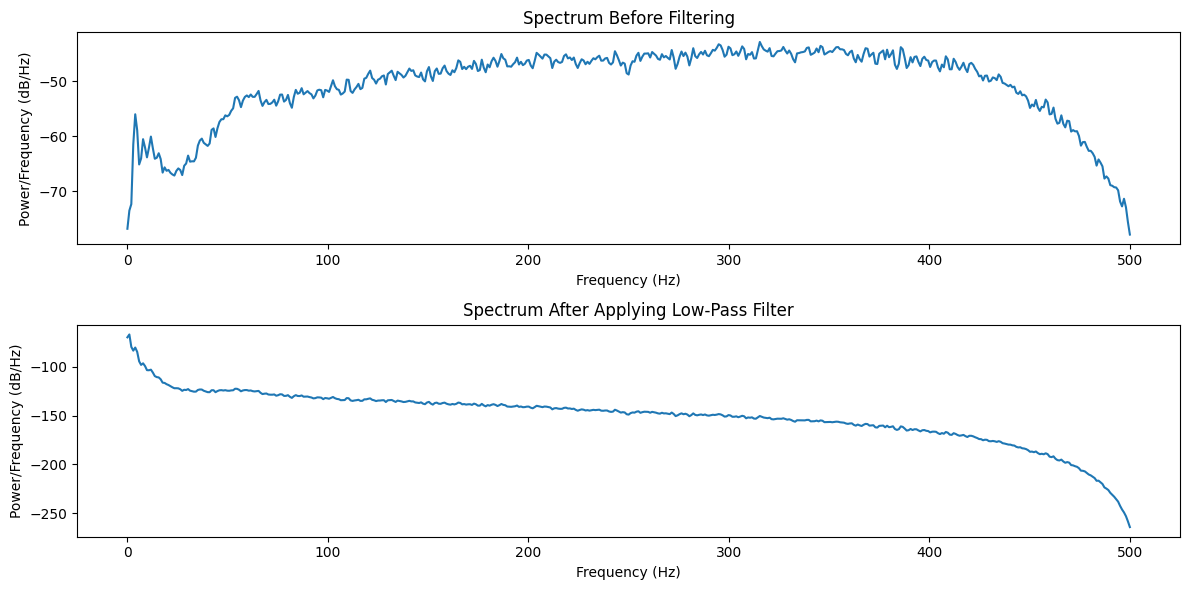

In [5]:
# For the Tricep Signal

filtered_emg2 = filtfilt(b, a, data_2)

# Before filtering
frequencies_before, spectrum_before = welch(data_2, fs=fs, nperseg=1024)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencies_before, 10 * np.log10(spectrum_before))
plt.title('Spectrum Before Filtering')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

# After filtering
frequencies_after2, spectrum_after2 = welch(filtered_emg2, fs=fs, nperseg=1024)
plt.subplot(2, 1, 2)
plt.plot(frequencies_after2, 10 * np.log10(spectrum_after2))
plt.title('Spectrum After Applying Low-Pass Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

# Showing both plots
plt.tight_layout()
plt.show()


### Part B

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


combined_data = np.vstack((filtered_emg, filtered_emg2)).T

# Splitting the data (80% training, 20% test)
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42)

# Normalization (Second method)
scaler = StandardScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)


### Part C

In [7]:
import pandas as pd


# Function to create sliding windows
def rolling_window(data, window_length, step):
    windows = []
    for i in range(0, len(data) - window_length + 1, step):
        window = data[i:i + window_length]
        windows.append(window)
    return windows


# Defining the variables
f_sampling = 320
w = int(0.21*f_sampling)
step = int(0.004*f_sampling)

Data_1 = pd.DataFrame(train_data)
Data_1['Time'] = np.arange(0, len(train_data)/f_sampling, 1/f_sampling)

Data_2 = pd.DataFrame(test_data)
Data_2['Time'] = np.arange(0, len(test_data)/f_sampling, 1/f_sampling)


# Applying the function to the train and test data 
windows_1 = rolling_window(Data_1['Time'], w, step)
windows_2 = rolling_window(Data_2['Time'], w, step)


### Part D

In [8]:
# Defining the dataframe containing the features
df = pd.DataFrame()
df_test = pd.DataFrame() 


for window in windows_1:

    # Assigning the labels
    time_start = window.iloc[0]
    time_end = window.iloc[-1]

    if 0 <= time_start <= 21.33 and 0 <= time_end <= 21.33:
        label_name = "neutral"
    elif 21.33 < time_start <= 39.38 and 21.33 < time_end <= 39.38:
        label_name = "open"
    elif 39.38 < time_start <= 64.43 and 39.38 < time_end <= 64.43:
        label_name = "grasp"
    elif 64.43 < time_start <= 89.33 and 64.43 < time_end <= 89.33:
        label_name = "extension"
    elif time_end > 89.33:
        label_name = "flexion"
    else:
        label_name = "unknown"  # You can handle other cases as needed
    
    # Std
    std = window.std()

    # Mean Absolute
    abs = window.abs()
    mav = abs.mean()

    # Var
    var = window.var()

    # Sum Absolute
    iav = abs.sum()
    
    # Adding the features to the dataframe
    new_row = pd.DataFrame({'Label': [label_name], 'MAV': [mav], 'STD': [std], 'VAR': [var], 'IAV': [iav]})
    df = pd.concat([df, new_row], ignore_index=True)

display(df)

,Label,MAV,STD,VAR,IAV
0,neutral,0.103125,0.060891,0.003708,6.909375
1,neutral,0.106250,0.060891,0.003708,7.118750
2,neutral,0.109375,0.060891,0.003708,7.328125
3,neutral,0.112500,0.060891,0.003708,7.537500
4,neutral,0.115625,0.060891,0.003708,7.746875
...,...,...,...,...,...
34115,flexion,106.712500,0.060891,0.003708,7149.737500
34116,flexion,106.715625,0.060891,0.003708,7149.946875
34117,flexion,106.718750,0.060891,0.003708,7150.156250
34118,flexion,106.721875,0.060891,0.003708,7150.365625


In [9]:
# Repeating the task for the test data frame 

for window in windows_2:
    
    time_start = window.iloc[0]
    time_end = window.iloc[-1]
    if 0 <= time_start <= 21.33 and 0 <= time_end <= 21.33:
        label_name = "neutral"
    elif 21.33 <= time_start <= 39.38 and 21.33 <= time_end <= 39.38:
        label_name = "open"
    elif 39.38 <= time_start <= 64.43 and 39.38 <= time_end <= 64.43:
        label_name = "grasp"
    elif 64.43 <= time_start <= 89.33 and 64.43 <= time_end <= 89.33:
        label_name = "extension"
    elif time_end > 89.33:
        label_name = "flexion"
    else:
        label_name = "unknown"  # You can handle other cases as needed
    
    # Std
    std = window.std()

    # Mean Absolute
    abs = window.abs()
    mav = abs.mean()

    # Var
    var = window.var()

    # Sum Absolute
    iav = abs.sum()
    
    new_row = pd.DataFrame({'Label': [label_name], 'MAV': [mav], 'STD': [std], 'VAR': [var], 'IAV': [iav]})
    df_test = pd.concat([df_test, new_row], ignore_index=True)
    
display(df_test)

,Label,MAV,STD,VAR,IAV
0,neutral,0.103125,0.060891,0.003708,6.909375
1,neutral,0.106250,0.060891,0.003708,7.118750
2,neutral,0.109375,0.060891,0.003708,7.328125
3,neutral,0.112500,0.060891,0.003708,7.537500
4,neutral,0.115625,0.060891,0.003708,7.746875
...,...,...,...,...,...
8477,open,26.593750,0.060891,0.003708,1781.781250
8478,open,26.596875,0.060891,0.003708,1781.990625
8479,open,26.600000,0.060891,0.003708,1782.200000
8480,open,26.603125,0.060891,0.003708,1782.409375


### Part E

In [10]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score


train_data = df[['MAV', 'STD', 'VAR', 'IAV']]
train_labels = df['Label'].astype(str)


test_data = df_test[['MAV', 'STD', 'VAR', 'IAV']]
test_labels = df_test['Label'].astype(str)

# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_data, train_labels)
knn_predictions = knn_classifier.predict(test_data)

knn_conf_matrix = confusion_matrix(test_labels, knn_predictions)
knn_accuracy = accuracy_score(test_labels, knn_predictions)

print("\nKNN Confusion Matrix:")
print(knn_conf_matrix)
print("KNN Accuracy:", knn_accuracy)

#LDA
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(train_data, train_labels)
lda_predictions = lda_classifier.predict(test_data)

lda_conf_matrix = confusion_matrix(test_labels, lda_predictions)
lda_accuracy = accuracy_score(test_labels, lda_predictions)

print("LDA Confusion Matrix:")
print(lda_conf_matrix)
print("LDA Accuracy:", lda_accuracy)



KNN Confusion Matrix:
[[6760    0    0]
 [   0 1656    0]
 [   0    0   66]]
KNN Accuracy: 1.0
LDA Confusion Matrix:
[[6760    0    0]
 [ 346 1310    0]
 [  66    0    0]]
LDA Accuracy: 0.9514265503419005
